In [5]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import kstest
from sklearn.model_selection import train_test_split

data source: https://archive.ics.uci.edu/dataset/143/statlog+australian+credit+approval

In [6]:
# Feature metadata: maps column index to (name, type, original_label)
FEATURE_METADATA = {
    0: ('A1', 'categorical', 'a,b'),
    1: ('A2', 'numerical', 'continuous'),
    2: ('A3', 'numerical', 'continuous'),
    3: ('A4', 'categorical', 'p,g,gg'),
    4: ('A5', 'categorical', 'ff,d,i,k,j,aa,m,c,w,e,q,r,cc,x'),
    5: ('A6', 'categorical', 'ff,dd,j,bb,v,n,o,h,z'),
    6: ('A7', 'numerical', 'continuous'),
    7: ('A8', 'categorical', 't,f'),
    8: ('A9', 'categorical', 't,f'),
    9: ('A10', 'numerical', 'continuous'),
    10: ('A11', 'categorical', 't,f'),
    11: ('A12', 'categorical', 's,g,p'),
    12: ('A13', 'numerical', 'continuous'),
    13: ('A14', 'numerical', 'continuous'),
}

NUMERICAL_FEATURES = [name for idx, (name, ftype, _) in FEATURE_METADATA.items() if ftype == 'numerical']
CATEGORICAL_FEATURES = [name for idx, (name, ftype, _) in FEATURE_METADATA.items() if ftype == 'categorical']


In [7]:
# Read the dataset
df= pd.read_csv('data/australian.dat', sep=r'\s+', header=None)
# Rename columns as per description of each column name
col_names = [FEATURE_METADATA[i][0] for i in range(len(df.columns) - 1)] + ['A15_target']
df.columns = col_names
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15_target
0,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


In [8]:
df.shape

(690, 15)


## Overview
- **Rows**: 690 credit applications
- **Columns**: 15 (14 predictors + 1 binary target)
- **Target (A15)**: 1 = Approved (+), 2 = Denied (-)
- **Features**: 6 numerical + 8 categorical (coded as integers)


In [10]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   A1          690 non-null    int64  
 1   A2          690 non-null    float64
 2   A3          690 non-null    float64
 3   A4          690 non-null    int64  
 4   A5          690 non-null    int64  
 5   A6          690 non-null    int64  
 6   A7          690 non-null    float64
 7   A8          690 non-null    int64  
 8   A9          690 non-null    int64  
 9   A10         690 non-null    int64  
 10  A11         690 non-null    int64  
 11  A12         690 non-null    int64  
 12  A13         690 non-null    int64  
 13  A14         690 non-null    int64  
 14  A15_target  690 non-null    int64  
dtypes: float64(3), int64(12)
memory usage: 81.0 KB


## Data Quality
- No missing values in the provided file; each column contains 690 non-null entries.
- Column types: 6 numerical (continuous) and 8 categorical (integer-coded), plus 1 target.

In [11]:
df.describe()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15_target
count,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.00000,690.000000,690.000000,690.000000,690.000000,690.000000
mean,0.678261,31.568203,4.758725,1.766667,7.372464,4.692754,2.223406,0.523188,0.427536,2.40000,0.457971,1.928986,184.014493,1018.385507,0.444928
std,0.467482,11.853273,4.978163,0.430063,3.683265,1.992316,3.346513,0.499824,0.495080,4.86294,0.498592,0.298813,172.159274,5210.102598,0.497318
min,0.000000,13.750000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,0.000000,22.670000,1.000000,2.000000,4.000000,4.000000,0.165000,0.000000,0.000000,0.00000,0.000000,2.000000,80.000000,1.000000,0.000000
50%,1.000000,28.625000,2.750000,2.000000,8.000000,4.000000,1.000000,1.000000,0.000000,0.00000,0.000000,2.000000,160.000000,6.000000,0.000000
75%,1.000000,37.707500,7.207500,2.000000,10.000000,5.000000,2.625000,1.000000,1.000000,3.00000,1.000000,2.000000,272.000000,396.500000,1.000000
max,1.000000,80.250000,28.000000,3.000000,14.000000,9.000000,28.500000,1.000000,1.000000,67.00000,1.000000,3.000000,2000.000000,100001.000000,1.000000


## Feature Breakdown

### Numerical Features (6)
- **A2**: Continuous metric (mean ≈ 31.6, range 13.75–80.25) — possibly age or income measure
- **A3**: Continuous metric (median 2.75, right-skewed, max 28)
- **A7**: Continuous metric (mean ≈ 2.22, heavy tail; max 28.5) — outliers present; candidate for log/box-cox transform
- **A10**: Continuous metric (median 0, sparse) — months or duration
- **A13**: Continuous metric (mean ≈ 184, wide range 0–2000) — credit line or account balance
- **A14**: Continuous metric (mean ≈ 1018, extreme outliers; max 100001) — likely monetary; requires winsorization or log-transform

Exploratory Data Analysis

C:\Users\dell\AppData\Local\Temp\ipykernel_12684\1267035913.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='A15_target', ax=ax[1], palette='Set2')


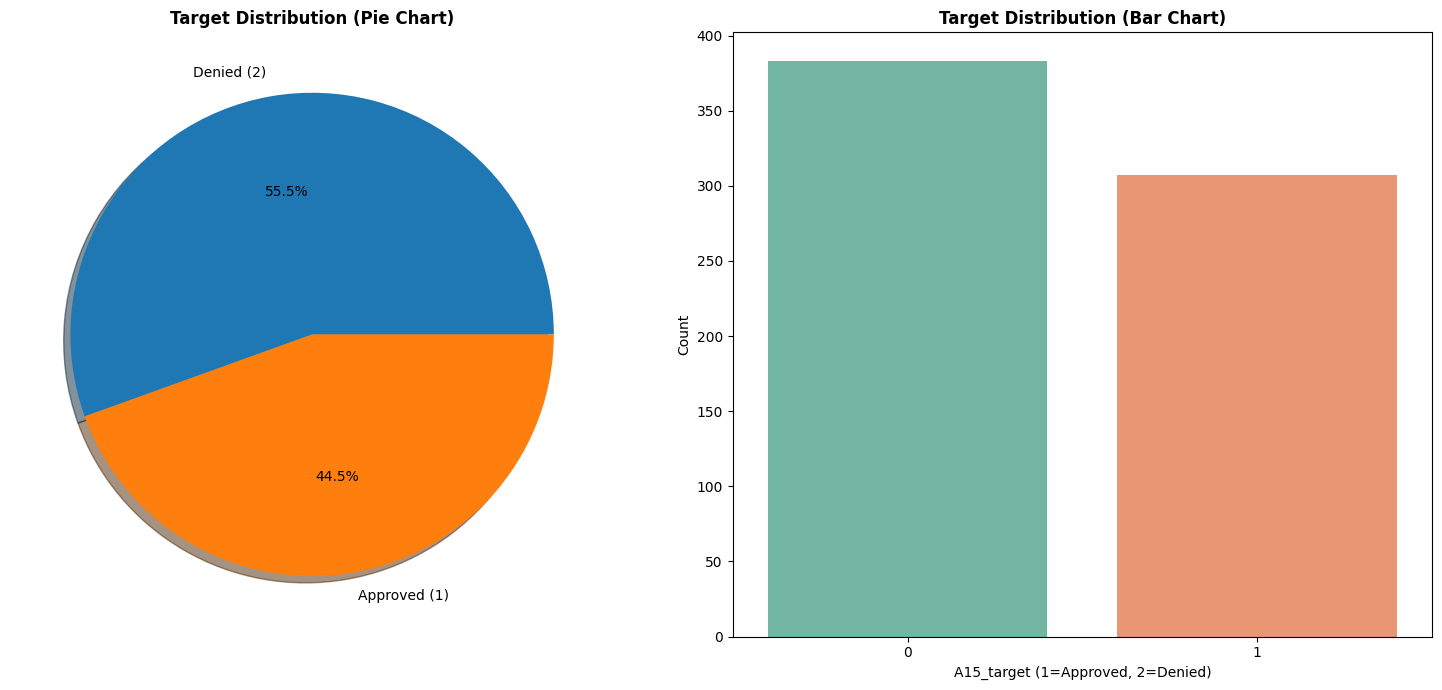

In [12]:
# Class Ratio - Target Variable Distribution
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Pie chart
df['A15_target'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0], shadow=True, labels=['Denied (2)', 'Approved (1)'])
ax[0].set_ylabel('')
ax[0].set_title('Target Distribution (Pie Chart)', fontsize=12, fontweight='bold')

# Count plot
sns.countplot(data=df, x='A15_target', ax=ax[1], palette='Set2')
ax[1].set_title('Target Distribution (Bar Chart)', fontsize=12, fontweight='bold')
ax[1].set_xlabel('A15_target (1=Approved, 2=Denied)', fontsize=10)
ax[1].set_ylabel('Count', fontsize=10)

plt.tight_layout()
plt.show()

## Target Variable (A15)
- **Counts**: 1 (Approved) = 307 (~44%), 2 (Denied) = 383 (~56%)
- **Class Imbalance**: Modest (44/56 split). Use stratified splits and consider class weighting for modeling.

Univariate Analysis

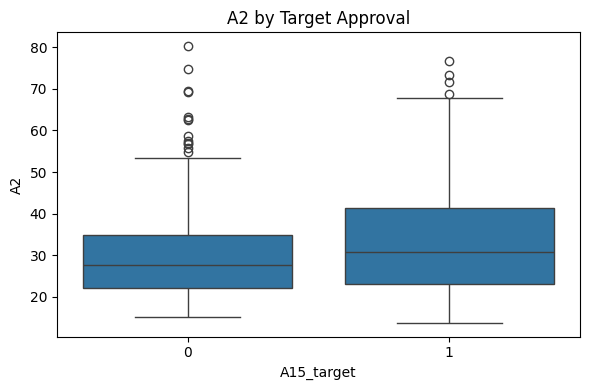

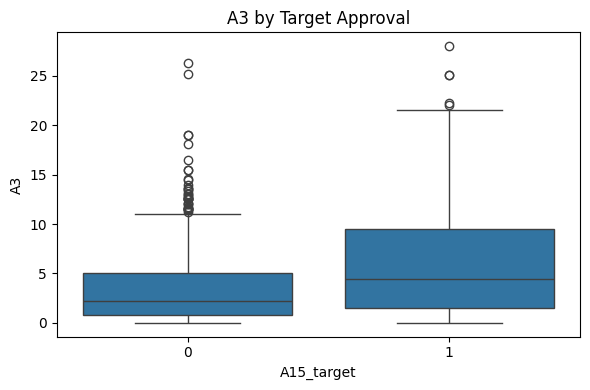

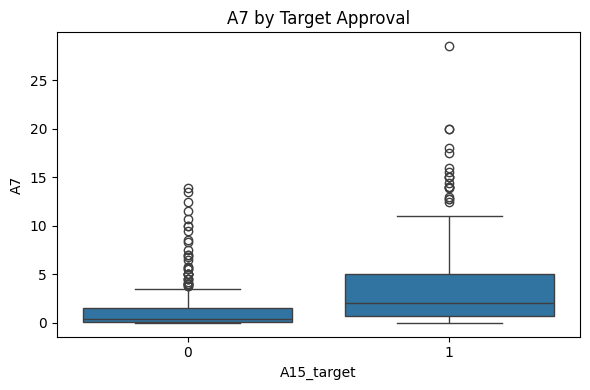

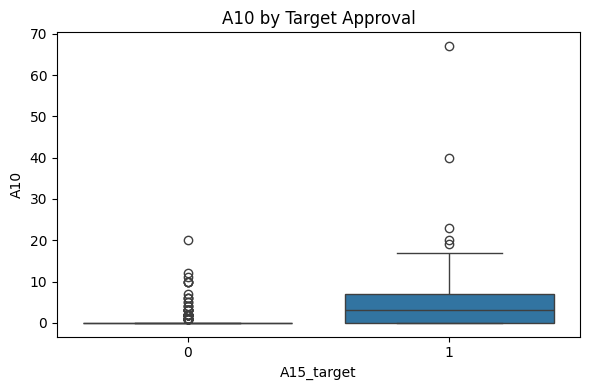

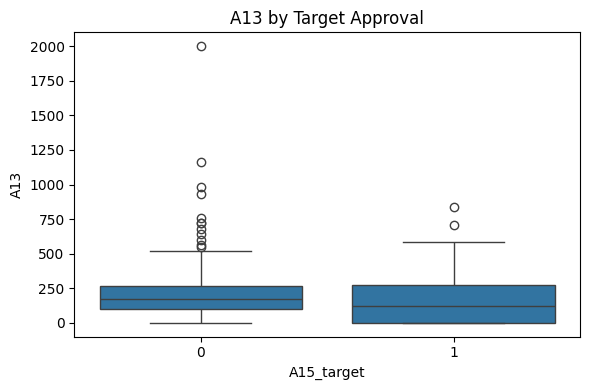

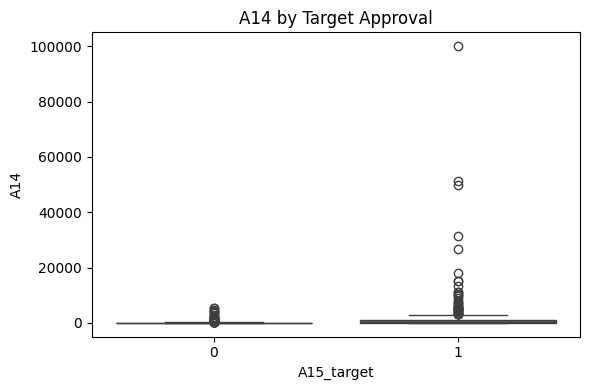

In [13]:
for feat in NUMERICAL_FEATURES:
    if feat in df.columns:
        # Histogram with KDE
        plt.figure(figsize=(6, 4))
        sns.histplot(df[feat], kde=True, bins=30)
        plt.title(f'Distribution: {feat}')
        plt.tight_layout()
        plt.close()

        # Boxplot by target
        plt.figure(figsize=(6, 4))
        sns.boxplot(x='A15_target', y=feat, data=df)
        plt.title(f'{feat} by Target Approval')
        plt.tight_layout()

# b. For Categorical Variables

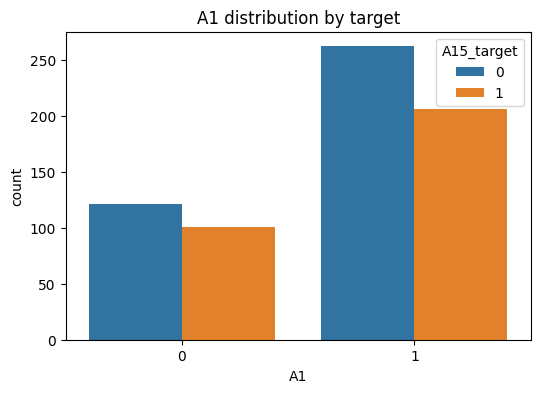

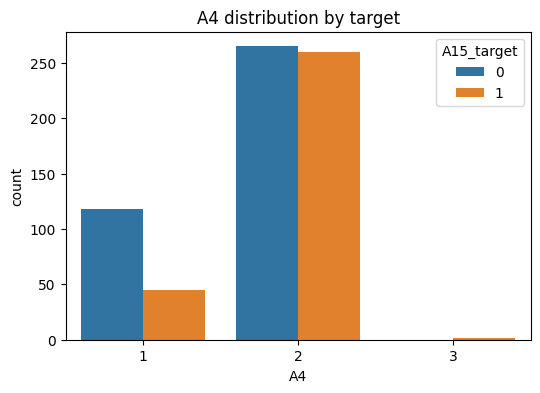

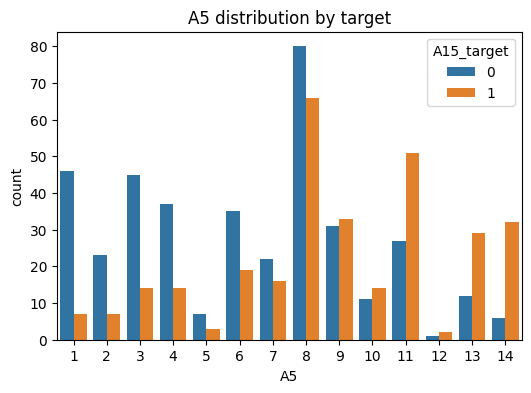

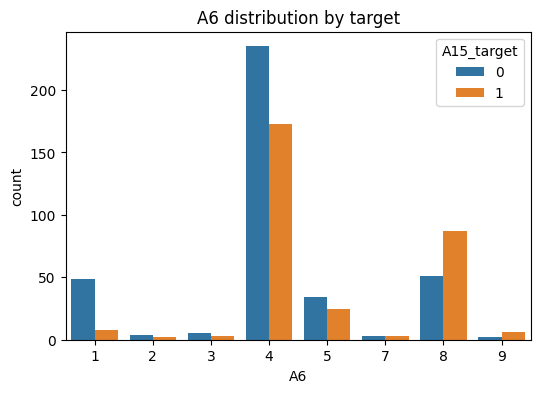

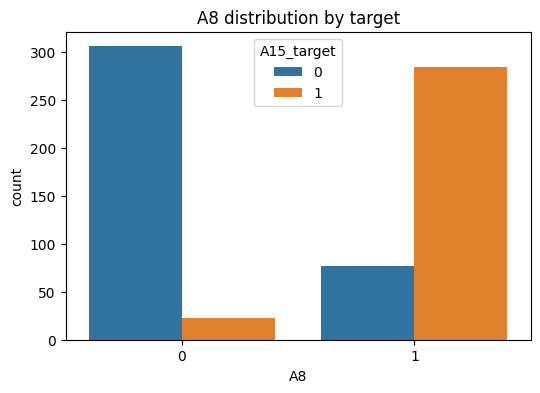

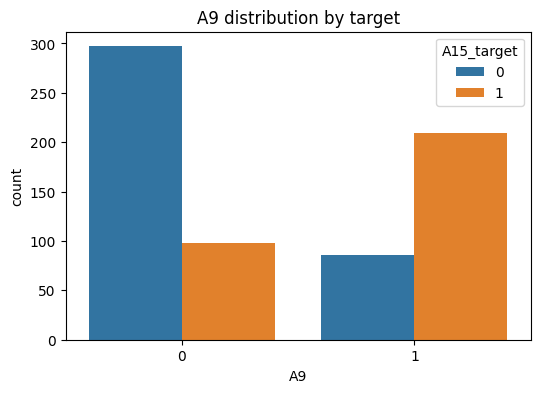

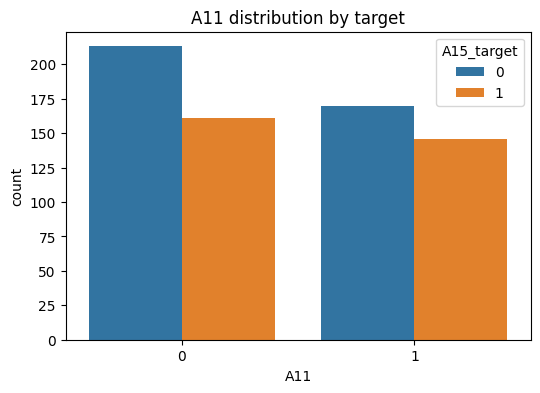

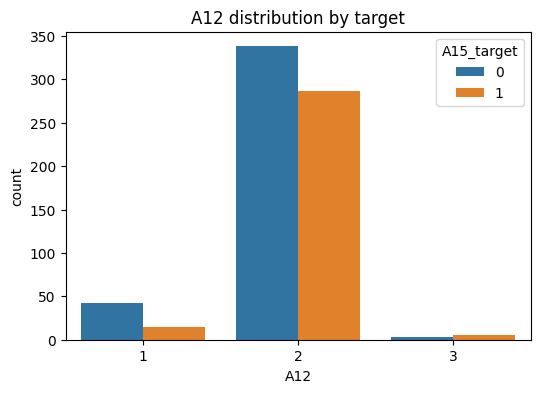

In [14]:
for feat in CATEGORICAL_FEATURES:
    if feat in df.columns:
        plt.figure(figsize=(6, 4))
        sns.countplot(x=feat, hue='A15_target', data=df)
        plt.title(f'{feat} distribution by target')

### Categorical Features (8)
- **A1**: Binary (0,1) — account status
- **A4**: Ordinal (1,2,3) — credit history (originally p, g, gg)
- **A5**: Nominal (1-14) — purpose of credit (14 categories)
- **A6**: Nominal (1-9) — occupation (9 categories)
- **A8**: Binary (0,1) — telephone listed
- **A9**: Binary (0,1) — foreign worker status
- **A11**: Binary (0,1) — prior default history
- **A12**: Ordinal (1,2,3) — employment status (originally s, g, p)

## Key Findings

### Descriptive Statistics
- **A2** (age-like): mean ≈ 31.6, IQR ≈ [22.67, 37.71], range 13.75–80.25 — reasonably symmetric
- **A3** (small continuous): median 2.75, right-skewed (max 28) — some extreme cases
- **A7** (debt/loan metric): mean ≈ 2.22, skewed distribution (75th percentile ≈ 2.63, max 28.5) — outliers; transform before modeling
- **A13** and **A14**: large spread; A14 has extreme value (100001) suggesting data entry issues or special cases — inspect and handle appropriately
- **A8, A9, A11**: binary indicators with moderate prevalence (30–50% positive class)

# Bivariate Analysis

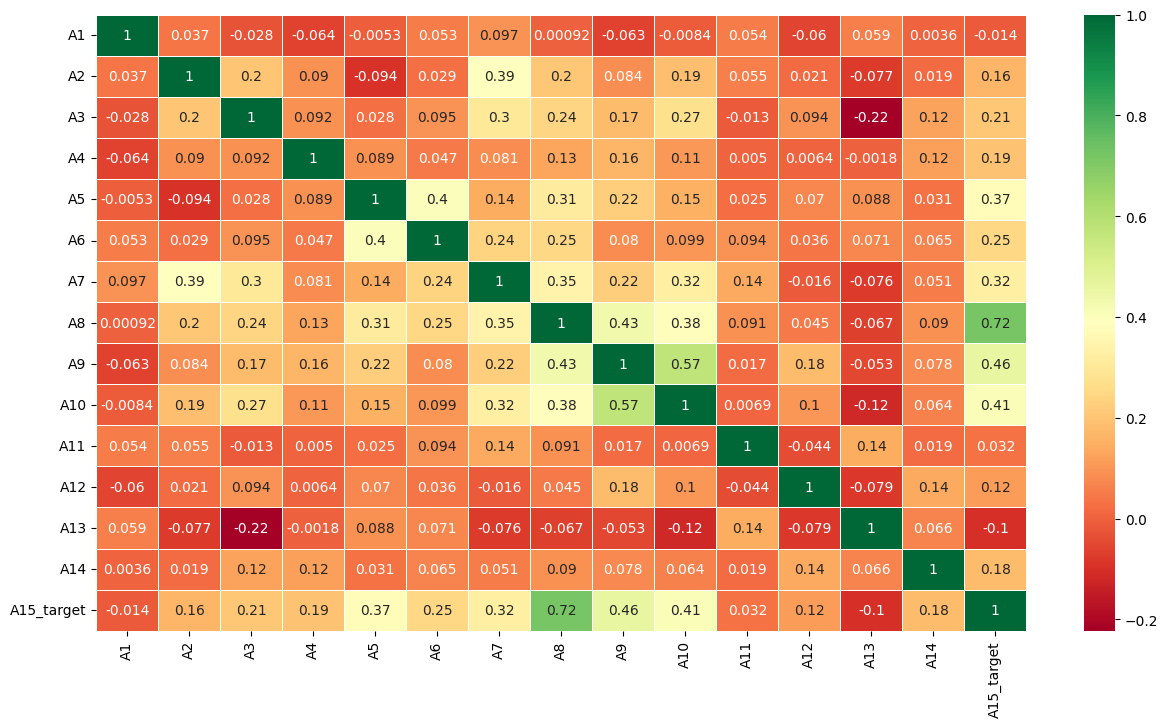

In [15]:
# Correlation Matrix
numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
corr = df[numeric_cols].corr()
sns.heatmap(corr,linewidths=.5,annot=True,cmap='RdYlGn')
fig=plt.gcf()
fig.set_size_inches(15,8)
plt.show()


### Predictive Power (Correlation with A15)
Ranked by absolute Pearson correlation:
1. **A8** (Telephone): 0.720 — strongest predictor; telephone listing strongly associated with approval
2. **A9** (Foreign worker): 0.458 — moderate positive correlation
3. **A10** (Months/tenure): 0.406 — duration in months correlated with approval
4. **A5** (Purpose): 0.374 — credit purpose matters for decision
5. **A7** (Debt metric): 0.322 — existing debt level affects approval

**Weak predictors** (r < 0.15):
- **A1**, **A11**, **A13**, **A14**, **A2**, **A12** — minimal linear correlation; may have nonlinear or weak effects

### Bivariate Insights
- **A8 & A9** show high correlation (0.46+), but both are strong approval predictors → consider multicollinearity in linear models
- **Group statistics**: Approved applicants (A15=1) have higher means/medians for A8, A9, A10, A5, A7 vs. denied applicants
  - E.g., A8 mean: 0.20 (denied) vs. 0.92 (approved); A9 mean: 0.22 (denied) vs. 0.68 (approved)

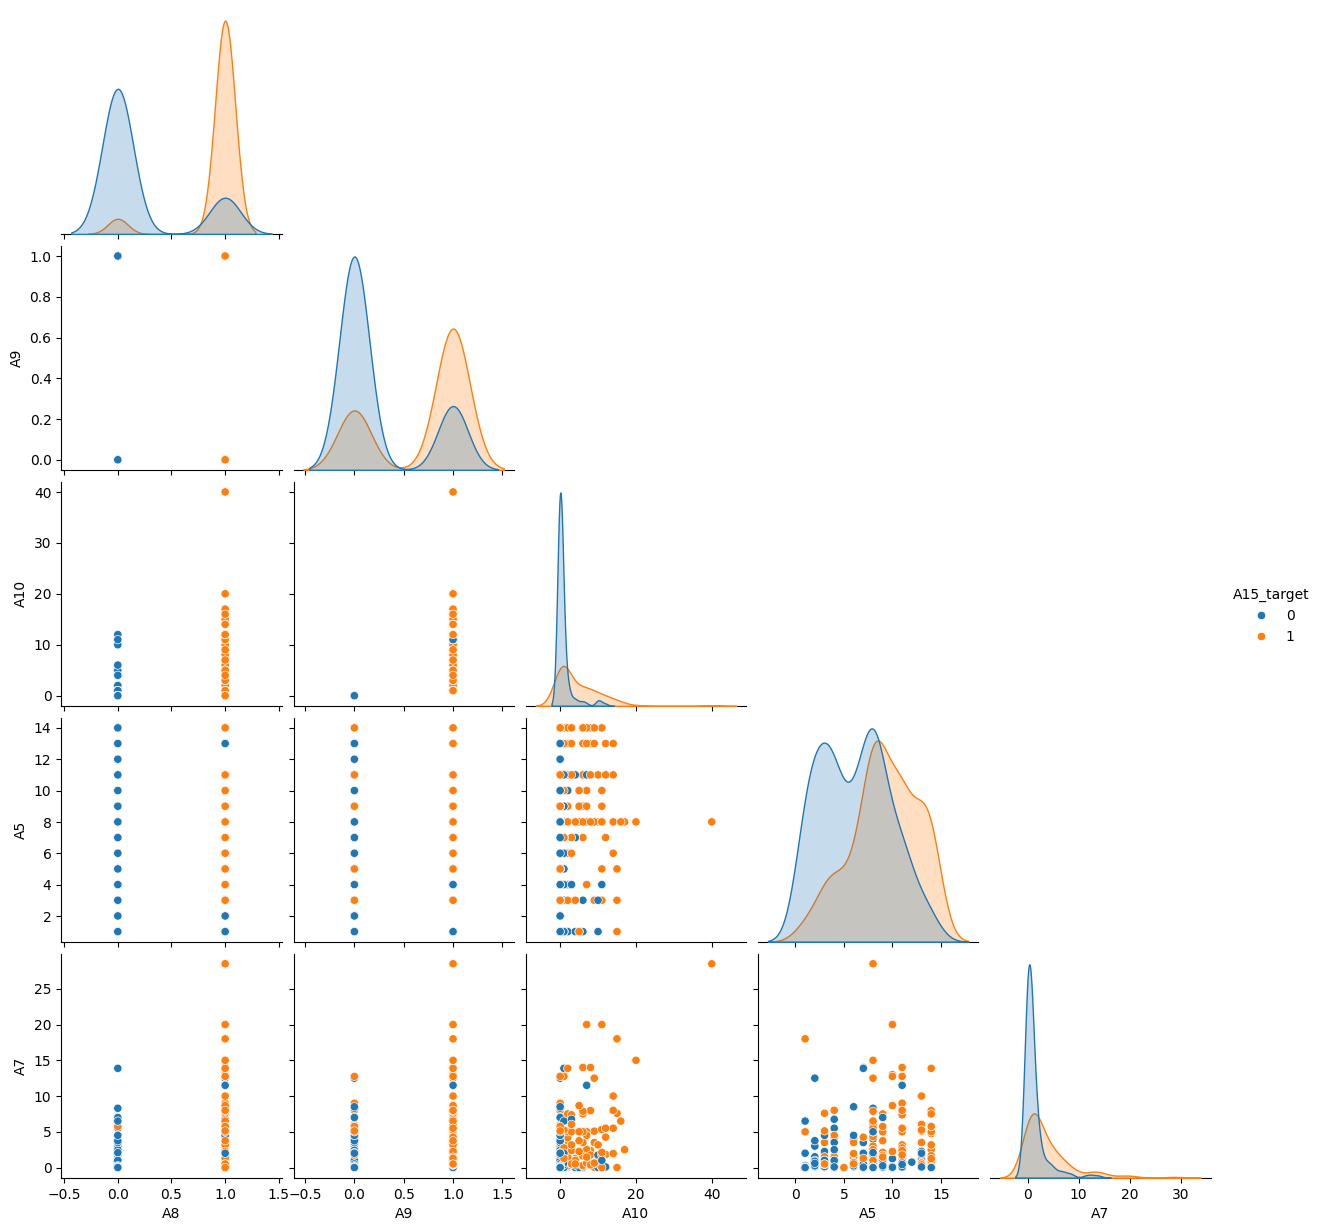

In [16]:
# Top 5 features correlated with target
cor_with_target = corr['A15_target'].abs().sort_values(ascending=False)

top_features = [c for c in cor_with_target.index if c != 'A15_target'][:5]

# Pairplot of top features
pp_df = df[top_features + ['A15_target']]
sample = pp_df.sample(n=min(300, len(pp_df)), random_state=1)
sns.pairplot(sample, hue='A15_target', corner=True)
plt.show()

Preprocessing the Data

Handling Categorical Attributes
Since the size of the dataset is small, One Hot Encoding separately will lead to different shapes in the training and testing data. So, we must OneHotEncode all the categorical variables before we split the dataset into training and testing data.

In [ ]:
def encode_categoricals(df, cats):
    if not cats:
        return df, []
    df_encoded = pd.get_dummies(df, columns=cats, drop_first=True)
    return df_encoded, cats

Spliting Data Into Train and Test dataset

In [17]:
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15_target
0,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


In [ ]:
test_size = 0.2
random_state = 42

X = df.drop(columns=['A15_target'])
y = df['A15_target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, stratify=y, random_state=random_state
)
train_df = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
test_df = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
train_path = os.path.join(OUT_DIR, 'train.csv')
test_path = os.path.join(OUT_DIR, 'test.csv')
train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)
